In [764]:
import pandas as pd
import numpy as np
import os

In [765]:
"""
Класс логистической регрессии был модифицирован и теперь метод fit возвращает список со значениями
функции ошибки (binary cross-entropy) на каждой итерации обучения.

Вы можете сравнивать графики функции ошибки для модели, обученной на `сырых данных` (пункт 1.1), и для модели, 
обученной на трансформированных данных (данные из пункта 1.3), для анализа влияния трансформаций на динамику обучения модели 
(ускорение обучения, ошибка ниже на первой итерации и т.д.).
"""


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def binary_cross_entropy(pred, label):
    return -np.mean(label * np.log(pred + 1e-6) + (1. - label) * np.log(1 - pred + 1e-6))


class LogisticRegression:
    def __init__(self, dim=2):
        rng = np.random.default_rng(seed=0)
        self.w = rng.normal(size=(dim, 1)) / np.sqrt(dim)
        self.b = np.zeros((1,))

    def predict(self, x, probs=False):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        x = x.dot(self.w) + self.b
        p = sigmoid(x)
        if probs:
            return p
        return np.array(p > 0.5).astype('int32')

    def fit(self, x, y, iters=300, lr=0.1):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        # y - np.array размернсоти [N]
        #     Массив меток (правильных ответов).
        assert len(x) == len(y), \
            "Количество экземпляров в массиве X не равно количеству меток в массиве Y. " + \
            f"Полученные размеры: len(X) = {len(x)}, len(Y) = {len(y)}."
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        y = y.reshape(-1, 1)
        loss = []
        for i in range(iters):
            preds = self.predict(x, probs=True)
            self.w -= lr * x.T.dot(preds - y) / y.shape[0]
            self.b -= lr * np.mean(preds - y, axis=0)
            loss.append(binary_cross_entropy(preds, y))
        return loss

In [766]:
def load_data(folder_path):
    x_train = pd.read_csv(os.path.join(folder_path, 'x_train.csv'))
    y_train = pd.read_csv(os.path.join(folder_path, 'y_train.csv'))
    x_test = pd.read_csv(os.path.join(folder_path, 'x_test.csv'))
    y_test = pd.read_csv(os.path.join(folder_path, 'y_test.csv'))
    return x_train, y_train, x_test, y_test

In [767]:
x_train, y_train, x_test, y_test = load_data('lr3_dataset/')
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [768]:
x_train.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,user_age,tweets_freq,followers_growth_rate,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length
0,38278,19692,3289,40071,335,0,1,4278,8.947639,4.603086,0.768817,9.366760,0.078308,5.987230,10,0,11,0,136
1,97523,54632,3544,1563,1091,0,0,4583,21.279293,11.920576,0.773293,0.341043,0.238054,15.415350,13,2,13,2,156
2,13533,2835,1246,1217,95,0,1,4629,2.923526,0.612443,0.269173,0.262908,0.020523,2.275281,7,2,11,0,119
3,13159,13950,2009,9477,161,0,0,4256,3.091870,3.277726,0.472039,2.226739,0.037829,6.943753,14,0,14,0,108
4,34670,19234,544,6587,121,1,1,3280,10.570122,5.864024,0.165854,2.008232,0.036890,35.356618,6,0,16,0,159


В данной лабораторной работе будет практиковаться обработка данных на примере датасета для задачи распознавания ботов в социальной сети Твиттер. Класс 0 означает человек, класс 1 означает бот. `Обучите модель так, чтобы вероятность пропуска бота составляла менее 4% (данный порог может быть ослаблен в зависимости от общих результатов лабораторных). Значение метрики F1 должно быть не менее 0.95.`

Требование: использовать лишь 10 признаков (это могут быть либо сгенерированные признаки, либо отобранные).


Допускается коллаборация (использование подходов к обработке данных, придуманных другими студентами) при условии ссылки на автора подхода в комментариях к коду (фамилия и инициалы).


## 1.1 Обучение baseline модели


Указание: `в данном пункте не применяйте трансформации к данным за рамками указанных`. Это необходимо для того, чтобы вы могли проводить сравнение в дальнейшем для лучшего понимания влияния вашего подхода к обработке данных на качество модели. Обучение baseline модели - стандартная практика, что даёт вам минимально рабочую модель и при этом позволяет отслеживать ваш прогресс.


In [769]:
from sklearn.decomposition import PCA

N_FEATURES = 10

# (loss, xt, yt, model)
MODELS_PACK: list[set[str, list, np.ndarray,
                      np.ndarray, LogisticRegression]] = []

# Снизьте размерность данных одним из способов:
# 1. вручную отобрав 10 признаков
MANUAL_FEATURES = [
    'is_default_profile',
    'is_profile_use_background_image',
    'friends_growth_rate',
    'favourites_growth_rate',
    'listed_growth_rate',
    'screen_name_length',
    'num_digits_in_screen_name',
    'length_of_name',
    'num_digits_in_name',
    'description_length'

]
# MANUAL_FEATURES = [
#     'description_length' for _ in range(N_FEATURES)
# ]
man_x_train = x_train[MANUAL_FEATURES].to_numpy()

# 2. используя PCA (from sklearn.decomposition import PCA)
pca = PCA(n_components=N_FEATURES)
pca.fit(x_train)
pca_x_train = pca.transform(x_train)

# Указание: не нормализуйте данные (min/max, mean/std и прочее).

In [770]:
# Обучите модель логистической регрессии на данных из клетки выше.

man_lr = LogisticRegression(N_FEATURES)
man_loss = man_lr.fit(man_x_train, y_train)

pca_lr = LogisticRegression(N_FEATURES)
pca_loss = pca_lr.fit(pca_x_train, y_train)

/tmp/ipykernel_7825/1736855544.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


/tmp/ipykernel_7825/1736855544.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Manual features               precision    recall  f1-score   support

           0       1.00      0.08      0.14       372
           1       0.24      1.00      0.39       108

    accuracy                           0.29       480
   macro avg       0.62      0.54      0.27       480
weighted avg       0.83      0.29      0.20       480

PCA               precision    recall  f1-score   support

           0       0.80      0.89      0.84       372
           1       0.37      0.22      0.28       108

    accuracy                           0.74       480
   macro avg       0.58      0.56      0.56       480
weighted avg       0.70      0.74      0.71       480



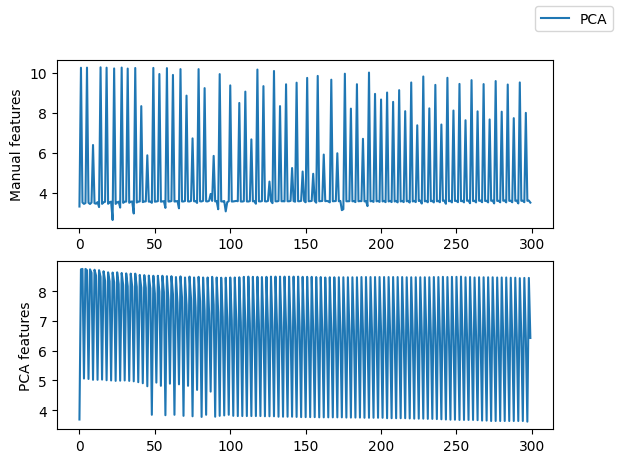

In [771]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
# Оцените качество обученной модели (точность, матрица ошибок), взгляните на динамику изменения функции ошибки в ходе обучения.

man_predicted_y = man_lr.predict(x_test[MANUAL_FEATURES])
print('Manual features', classification_report(y_test, man_predicted_y))

pca_predicted_y = pca_lr.predict(pca.transform(x_test))
print('PCA', classification_report(y_test, pca_predicted_y))

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.set_ylabel('Manual features')
ax1.plot(np.arange(len(man_loss)), man_loss)

ax2.set_ylabel('PCA features')
ax2.plot(np.arange(len(pca_loss)), pca_loss, label='PCA')
fig.legend()

## 1.2 Анализ данных


In [772]:
x_train.columns

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'is_default_profile',
       'is_profile_use_background_image', 'user_age', 'tweets_freq',
       'followers_growth_rate', 'friends_growth_rate',
       'favourites_growth_rate', 'listed_growth_rate',
       'followers_friends_ratio', 'screen_name_length',
       'num_digits_in_screen_name', 'length_of_name', 'num_digits_in_name',
       'description_length'],
      dtype='object')

In [773]:
def perc(x_train, y_train):
    perc = np.percentile(x_train, 95)
    left_lim, right_lim = 0, perc
    xt = np.clip(left_lim, right_lim, x_train.copy())
    yt = np.clip(left_lim, right_lim, y_train.copy())
    return xt, yt


def explain(HIST_BY: str, comments: str):
    x_perc, y_perc = perc(x_train[HIST_BY], y_train.flatten())
    pd.DataFrame(x_perc).hist(by=y_perc.flatten(), sharey=True, sharex=True,
                              legend=HIST_BY, figsize=(10, 5), bins=50)
    print(comments)

In [774]:
# Проведите анализ данных (наличие выбросов, визуализация распределения отдельных признаков и т.д.).

In [775]:
print(f'Колличество ботов: {len(y_train[y_train == 1])}')
print(
    f'Колличество пользователей: {len(y_train) - len(y_train[y_train == 1])}')
print(f'Всего {len(y_train)}')

Колличество ботов: 492
Колличество пользователей: 1428
Всего 1920



    Статусы ботов схожи с человеческими
    


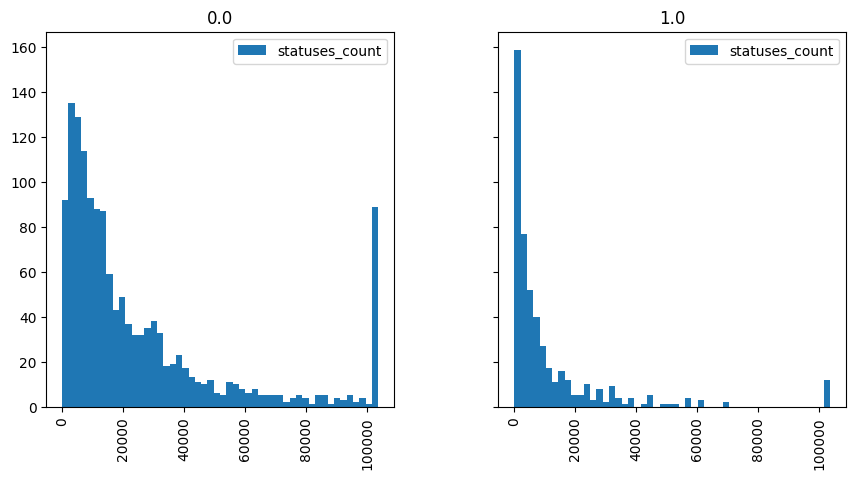

In [776]:
explain(
    'statuses_count',
    """
    Статусы ботов схожи с человеческими
    """)

Колличество подписчиков у ботов около нулевое


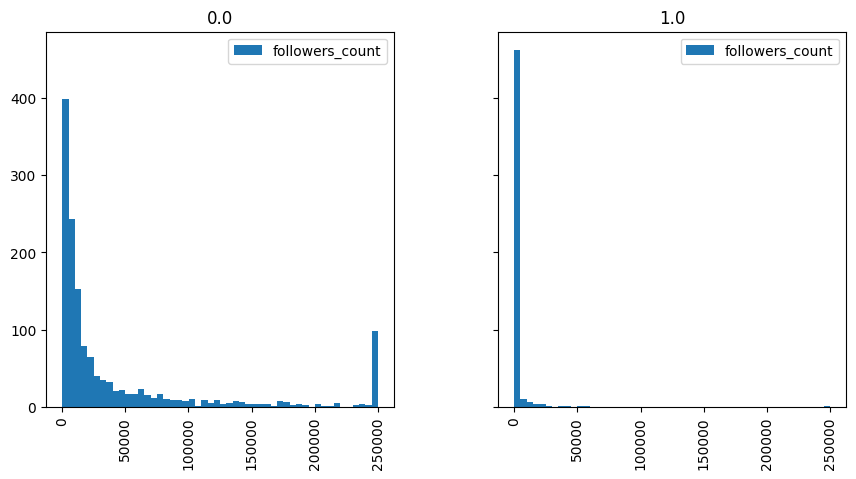

In [777]:
explain(
    'followers_count',
    'Колличество подписчиков у ботов около нулевое'
)


    То же самое и с друзьями
    


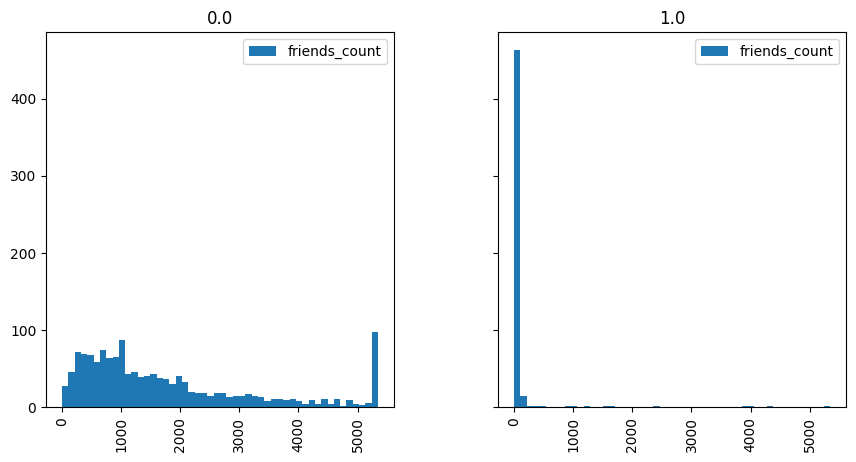

In [778]:
explain(
    'friends_count',
    """
    То же самое и с друзьями
    """
)

Боты практически не взаимодействуют с интерактивными возможностями соц сети, поэтому подсчёты объектных единиц такого плана всегда около 0


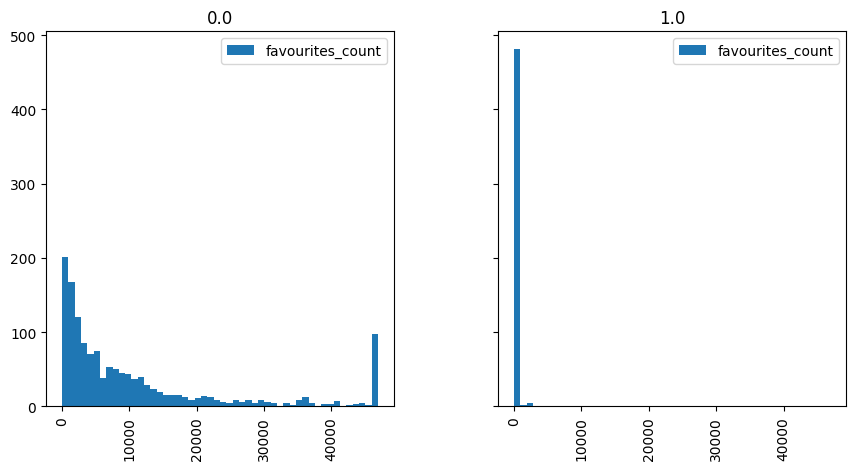

In [779]:
explain(
    'favourites_count',
    "Боты практически не взаимодействуют с интерактивными возможностями соц сети, поэтому подсчёты объектных единиц такого плана всегда около 0"
)

Также как favourites_count


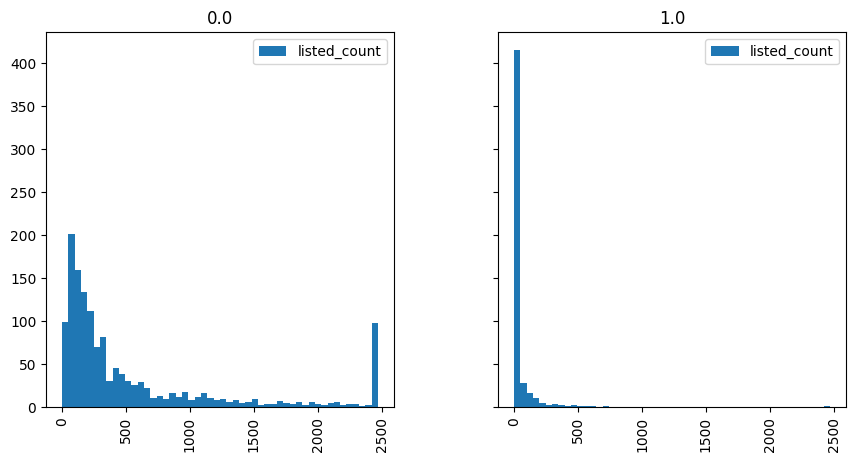

In [780]:
explain('listed_count', 'Также как favourites_count')


    Реальные пользователи чаще всего используют дефолтный аккаунт,
    Боты распределны равномерно
    
    Однозначно определить по данному параметру бота и не бота не получится, так 
    как такая равномерность распределения ботов может быть обусловлена недостатоком данных по их классу
    


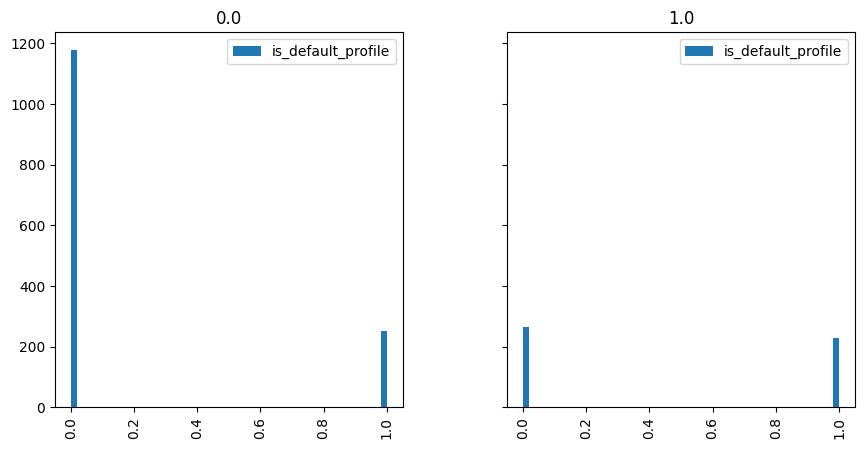

In [781]:
explain('is_default_profile',
    """
    Реальные пользователи чаще всего используют дефолтный аккаунт,
    Боты распределны равномерно
    
    Однозначно определить по данному параметру бота и не бота не получится, так 
    как такая равномерность распределения ботов может быть обусловлена недостатоком данных по их классу
    """
)

То же самое по этому параметру


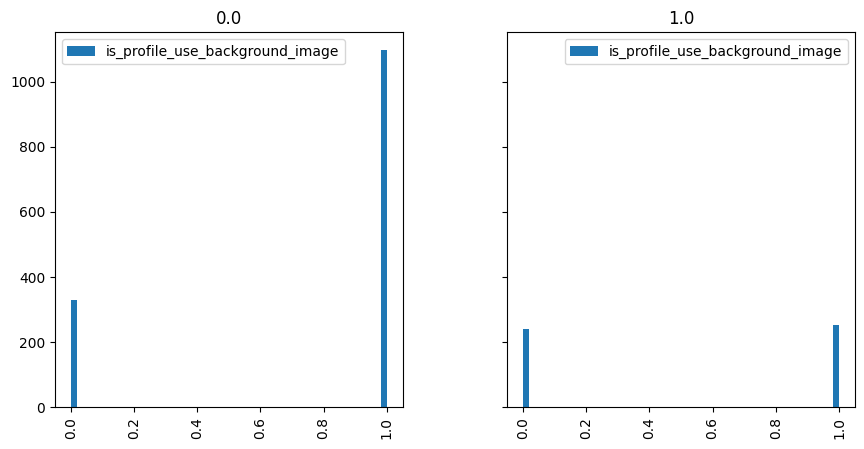

In [782]:
explain('is_profile_use_background_image', 'То же самое по этому параметру')


    User_age у ботов обычно не достигает 3000, что может свидетельствовать о том
    что аккаунты ботов создаются чаще.
    Для пользователей 3000 является приблизительно левой границей, соответственно люди пользутся своими аккаунтами с момента регистрации от того это число столь большое
    


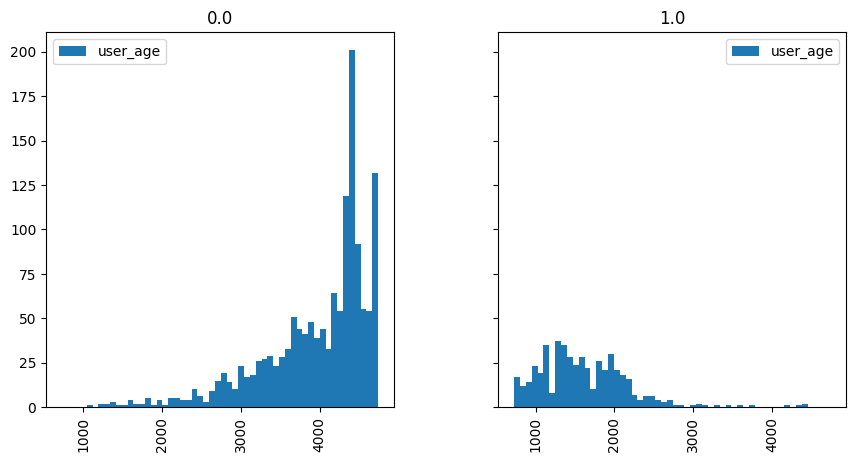

In [783]:
explain(
    'user_age',
    """
    User_age у ботов обычно не достигает 3000, что может свидетельствовать о том
    что аккаунты ботов создаются чаще.
    Для пользователей 3000 является приблизительно левой границей, соответственно люди пользутся своими аккаунтами с момента регистрации от того это число столь большое
    """
)


    По колличеству генерируемых постов боты 'мимикрируют' под среднестатистического пользователя,
    что можно увидеть по динамике распределения.
    
    Различия по оси Y обусловлены неравномерностью классов ботов и пользователей
    


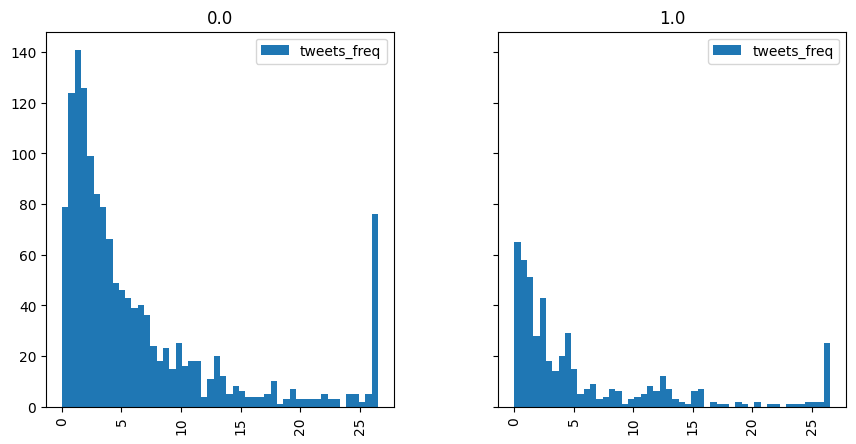

In [784]:
explain(
    'tweets_freq',
    """
    По колличеству генерируемых постов боты 'мимикрируют' под среднестатистического пользователя,
    что можно увидеть по динамике распределения.
    
    Различия по оси Y обусловлены неравномерностью классов ботов и пользователей
    """
)


    Частота подписок на ботов практически всегда около 0
    Но в целом это же относится и к реальным пользователям
    


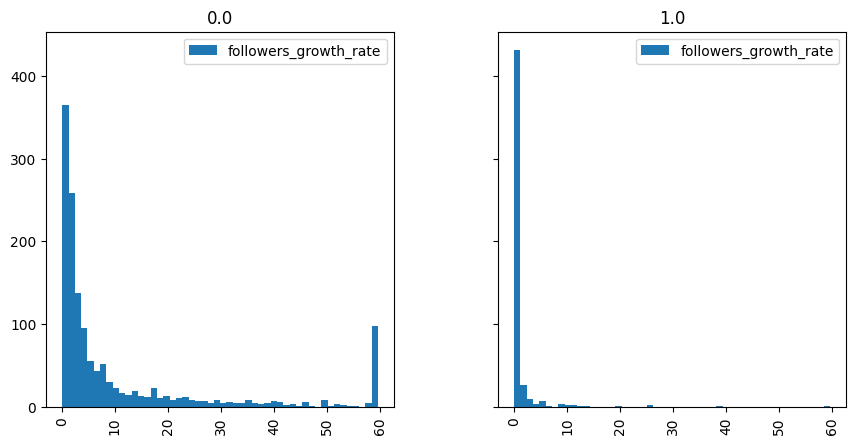

In [785]:
explain(
    'followers_growth_rate',
    """
    Частота подписок на ботов практически всегда около 0
    Но в целом это же относится и к реальным пользователям
    """
)


    Однако по частоте добавления друзей
    Можно однозначно определить бота и человека
    
    Даже учитывая дизбаланс классов можно увидеть, что меньшинство людей, которые не добвляют друзей
    Когда для ботов этот параметр в основном равен 0
    


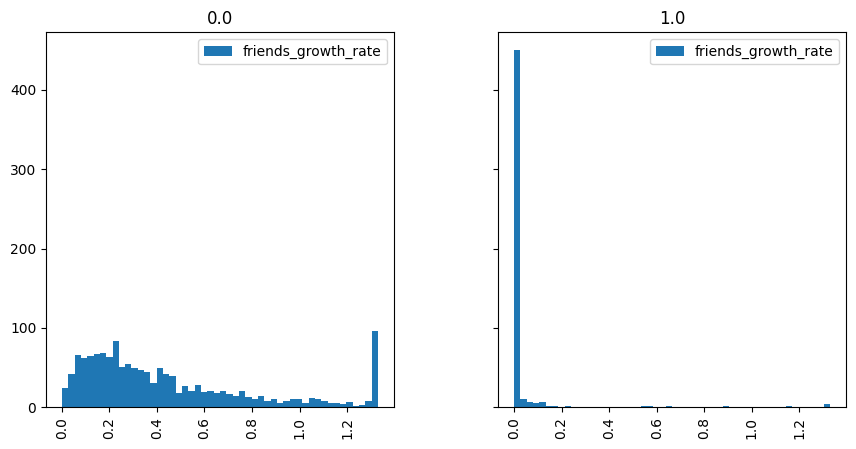

In [786]:
explain(
    'friends_growth_rate',
    """
    Однако по частоте добавления друзей
    Можно однозначно определить бота и человека
    
    Даже учитывая дизбаланс классов можно увидеть, что меньшинство людей, которые не добвляют друзей
    Когда для ботов этот параметр в основном равен 0
    """
)

Здесь также как favourites_count


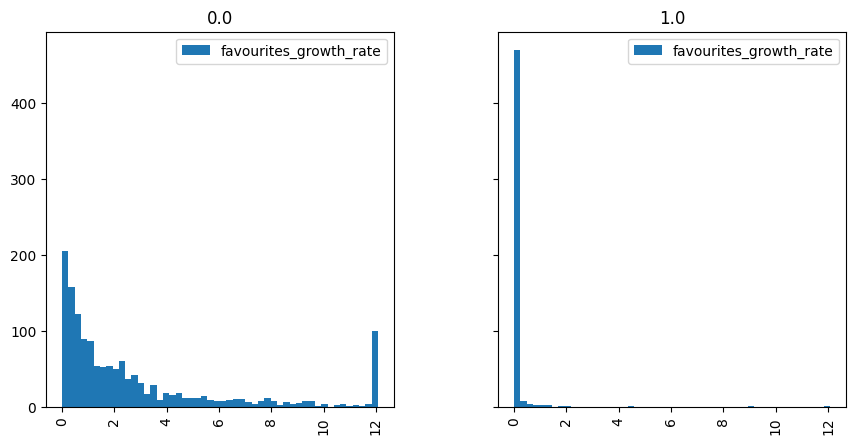

In [787]:
explain('favourites_growth_rate', 'Здесь также как favourites_count')


    Противоречивый показатель в плане смысловой состовляющей
    Так как учитывая, что у бота не может быть друзей, то данный показатель
    может отображать вспелсковые данные.
    
    Однако при определении класса можно пойти от обратного, у класса человек
    Данное соотношение практически нулевое
    


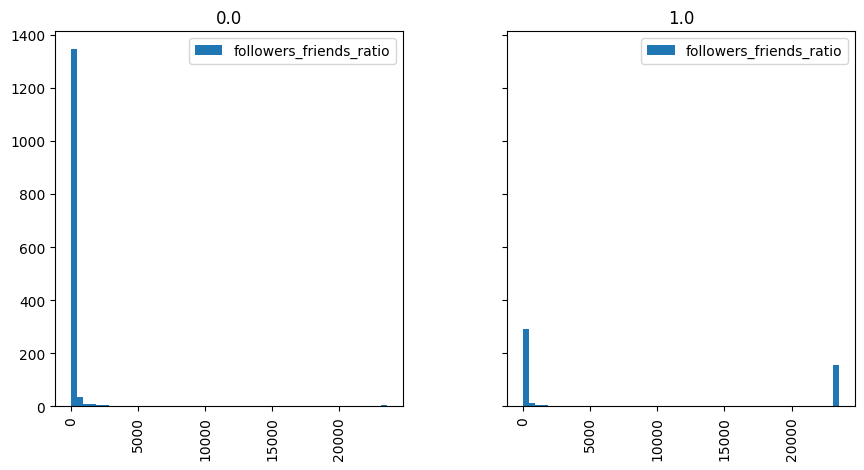

In [788]:
explain(
    'followers_friends_ratio',
    """
    Противоречивый показатель в плане смысловой состовляющей
    Так как учитывая, что у бота не может быть друзей, то данный показатель
    может отображать вспелсковые данные.
    
    Однако при определении класса можно пойти от обратного, у класса человек
    Данное соотношение практически нулевое
    """
)

In [789]:
SAME = ['listed_growth_rate', 'screen_name_length',
        'num_digits_in_screen_name', 'length_of_name', 'num_digits_in_name',]
print(
    f"""
    Оставшиеся показатели {SAME} 
    имеют похожую динамику распределения
    """
)


    Оставшиеся показатели ['listed_growth_rate', 'screen_name_length', 'num_digits_in_screen_name', 'length_of_name', 'num_digits_in_name'] 
    имеют похожую динамику распределения
    


In [790]:
#  Предложите идеи к обработке/улучшению качества данных.
# 0. Брать 95% перцентиль
# 1. Нормализовать данные
# 2. Среднее параметров "интерактивности"
# 3. Среднее параметров друзей и подписчиков
# 4. Бинарные араметры свести к формату "подозрения" относительно user_age
# 5. Убрать схожие между классами данные

## 1.3 Обработка данных


In [791]:
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler


class DTransformer:

    INTERACTIVE_PARAMS = [
        'favourites_count',
        'listed_count',
        'favourites_growth_rate',
    ]
    FOLOWERS_PARAMS = [
        'followers_count',
        'followers_growth_rate',
        'followers_friends_ratio',
    ]
    FRIENDS_PARAMS = [
        'friends_count',
        'friends_growth_rate',
        'followers_friends_ratio',
    ]
    # SUSPICIOS_PARAMS = [
    #     'is_default_profile',
    #     'is_profile_use_background_image',
    # ]
    SAME = [
        'screen_name_length',
        'num_digits_in_screen_name',
        'length_of_name',
        'num_digits_in_name',
        # 'description_length'
    ]

    def __init__(self) -> None:
        self.scaler = MinMaxScaler()
        self.sums: np.ndarray = None
        self.pca = PCA(N_FEATURES)

        self.user_age_mean = 0.0

    def fit(self, x):
        self.scaler.fit(x)
        data = self.data_change(x)
        self.pca.fit(data)

    def data_change(self, x: pd.DataFrame):
        x_mod = pd.DataFrame(self.scaler.transform(x), columns=x.columns)

        x_mod['followers_friends_ratio'] = 1 - x_mod['followers_friends_ratio']
        x_mod['favourites_growth_rate'] = 1 - x_mod['favourites_growth_rate']
        x_mod['friends_growth_rate'] = 1 - x_mod['friends_growth_rate']

        x_mod['followers_params'] = np.average(
            x_mod[self.FOLOWERS_PARAMS], axis=1)
        for name in self.FOLOWERS_PARAMS:
            if name in ['followers_friends_ratio', 'followers_count']:
                continue
            x_mod.pop(name)

        user_age = x_mod['user_age']
        x_mod['bot_suspicious'] = (1 - user_age)

        # x_mod['bot_suspicious'] *= (1 - x_mod['is_default_profile']) * \
        #     (1 - x_mod['is_profile_use_background_image'])
        x_mod.pop('is_default_profile')
        x_mod.pop('is_profile_use_background_image')

        x_mod['zeroed_statuses'] = (1 - user_age) * x_mod.pop('statuses_count')
        x_mod['friends_params'] = np.average(
            x_mod[self.FRIENDS_PARAMS], axis=1) * 2 - 0.5
        for name in self.FRIENDS_PARAMS:
            x_mod.pop(name)

        x_mod['interactive_params'] = x_mod['bot_suspicious'] * np.average(
            x_mod[self.INTERACTIVE_PARAMS], axis=1)
        for name in self.INTERACTIVE_PARAMS:
            if name in ['favourites_count', 'listed_count']:
                continue
            x_mod.pop(name)

        for name in self.SAME:
            x_mod.pop(name)
        return x_mod

    def transform(self, x: pd.DataFrame):
        mod = self.data_change(x)
        return self.pca.transform(mod)


perc = np.percentile(x_train, 95)
left_lim, right_lim = 0, perc
lim_x_train = np.clip(left_lim, right_lim, x_train.copy())
lim_y_train = np.clip(left_lim, right_lim, y_train.copy())

dt = DTransformer()
dt.fit(lim_x_train)
x_train_mod = dt.transform(lim_x_train)

x_test_mod = dt.transform(x_test)
dt.data_change(lim_x_train).describe()

,followers_count,favourites_count,listed_count,user_age,tweets_freq,listed_growth_rate,description_length,followers_params,bot_suspicious,zeroed_statuses,friends_params,interactive_params
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000
mean,0.494806,0.331752,0.037034,0.567901,0.010875,0.008036,0.651532,0.467989,0.432099,0.223053,0.819583,0.177212
std,0.411090,0.370819,0.100268,0.264952,0.031463,0.034658,0.253444,0.186252,0.264952,0.187050,0.217171,0.089181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000
25%,0.083698,0.004665,0.002464,0.316924,0.002099,0.000658,0.464706,0.352494,0.214232,0.089670,0.833100,0.100577
50%,0.387274,0.155044,0.009358,0.662377,0.004844,0.002014,0.717647,0.454722,0.337623,0.179537,0.858597,0.155705
75%,1.000000,0.601989,0.028163,0.785768,0.011135,0.005456,0.876471,0.665577,0.683076,0.287609,0.896366,0.255054
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.824943,1.000000,0.952810,1.415400,0.499211


## 1.4 Обучение итоговой модели


In [792]:
# Обучите модель на трансформированных данных.

lr = LogisticRegression(N_FEATURES)
final_loss = lr.fit(x_train_mod, y_train)
y_pred = lr.predict(x_test_mod)

Manual features               precision    recall  f1-score   support

           0       1.00      0.08      0.14       372
           1       0.24      1.00      0.39       108

    accuracy                           0.29       480
   macro avg       0.62      0.54      0.27       480
weighted avg       0.83      0.29      0.20       480

PCA               precision    recall  f1-score   support

           0       0.80      0.89      0.84       372
           1       0.37      0.22      0.28       108

    accuracy                           0.74       480
   macro avg       0.58      0.56      0.56       480
weighted avg       0.70      0.74      0.71       480

Features engineered               precision    recall  f1-score   support

           0       0.99      0.98      0.99       372
           1       0.94      0.96      0.95       108

    accuracy                           0.98       480
   macro avg       0.96      0.97      0.97       480
weighted avg       0.98      0.98 

/tmp/ipykernel_7825/1736855544.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


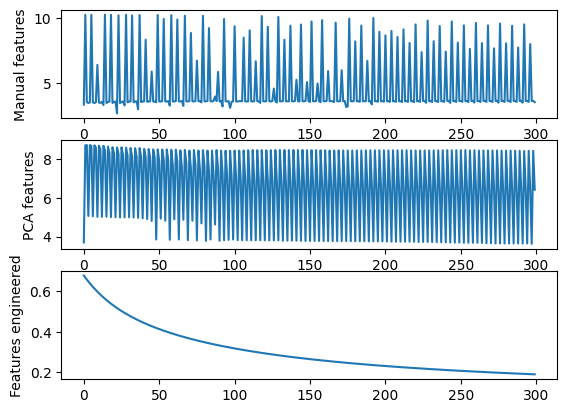

In [793]:
# Оцените качество обученной модели (точность, матрица ошибок).
# Взгляните (matplotlib) на динамику изменения функции ошибки в ходе обучения.

man_predicted_y = man_lr.predict(x_test[MANUAL_FEATURES])
print('Manual features', classification_report(y_test, man_predicted_y))

pca_predicted_y = pca_lr.predict(pca.transform(x_test))
print('PCA', classification_report(y_test, pca_predicted_y))
print('Features engineered', classification_report(y_test, y_pred))

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

ax1.set_ylabel('Manual features')
ax1.plot(np.arange(len(man_loss)), man_loss)

ax2.set_ylabel('PCA features')
ax2.plot(np.arange(len(pca_loss)), pca_loss, label='PCA')

ax3.set_ylabel('Features engineered')
ax3.plot(np.arange(len(final_loss)), final_loss, label='Features engineered')

In [794]:
# Сравните результат с моделью из пункта 1.1.
print("""
Выводы:
# Функция ошибки при обучении
Как видно из графиков отобранные данные дают меньший разброс функции ошибки
так как они находятся в рамках одного масштаба, благодря чему не происходит резких перекосов параметров w и b при обучении логистической регрессии

# Значение ошибки
Опять же из графиков можно увидеть, что значение ошибки уменьшилось в 10 раз, так как данные в себе несут больше информации

# Ошибочность идей 
В классе DTransformer есть закоментированные строки кода, которые были в качестве идеи, но в конечном итоге
при добавлении этих данных результирующее значение точности снижалось.
""")


Выводы:
# Функция ошибки при обучении
Как видно из графиков отобранные данные дают меньший разброс функции ошибки
так как они находятся в рамках одного масштаба, благодря чему не происходит резких перекосов параметров w и b при обучении логистической регрессии

# Значение ошибки
Опять же из графиков можно увидеть, что значение ошибки уменьшилось в 10 раз, так как данные в себе несут больше информации

# Ошибочность идей 
В классе DTransformer есть закоментированные строки кода, которые были в качестве идеи, но в конечном итоге
при добавлении этих данных результирующее значение точности снижалось.

